# Basic Imports & Setup

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

# Defining PowerProp Layers

In [ ]:
import math
import warnings

import torch
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn.modules.lazy import LazyModuleMixin
from torch.nn.modules import Module
from torch.nn.modules.utils import _single, _pair, _triple, _reverse_repeat_tuple
from torch._torch_docs import reproducibility_notes

from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
from typing import Optional, List, Tuple, Union

class _ConvNd_Power(Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']
    __annotations__ = {'bias': Optional[torch.Tensor]}

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]) -> Tensor:
        ...

    _in_channels: int
    _reversed_padding_repeated_twice: List[int]
    out_channels: int
    kernel_size: Tuple[int, ...]
    stride: Tuple[int, ...]
    padding: Union[str, Tuple[int, ...]]
    dilation: Tuple[int, ...]
    transposed: bool
    output_padding: Tuple[int, ...]
    groups: int
    padding_mode: str
    weight: Tensor
    bias: Optional[Tensor]

    def __init__(self,
                 alpha: float,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: Tuple[int, ...],
                 stride: Tuple[int, ...],
                 padding: Tuple[int, ...],
                 dilation: Tuple[int, ...],
                 transposed: bool,
                 output_padding: Tuple[int, ...],
                 groups: int,
                 bias: bool,
                 padding_mode: str,
                 device=None,
                 dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(_ConvNd_Power, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        valid_padding_strings = {'same', 'valid'}
        if isinstance(padding, str):
            if padding not in valid_padding_strings:
                raise ValueError(
                    "Invalid padding string {!r}, should be one of {}".format(
                        padding, valid_padding_strings))
            if padding == 'same' and any(s != 1 for s in stride):
                raise ValueError("padding='same' is not supported for strided convolutions")

        valid_padding_modes = {'zeros', 'reflect', 'replicate', 'circular'}
        if padding_mode not in valid_padding_modes:
            raise ValueError("padding_mode must be one of {}, but got padding_mode='{}'".format(
                valid_padding_modes, padding_mode))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.alpha = alpha
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        if isinstance(self.padding, str):
            self._reversed_padding_repeated_twice = [0, 0] * len(kernel_size)
            if padding == 'same':
                for d, k, i in zip(dilation, kernel_size,
                                   range(len(kernel_size) - 1, -1, -1)):
                    total_padding = d * (k - 1)
                    left_pad = total_padding // 2
                    self._reversed_padding_repeated_twice[2 * i] = left_pad
                    self._reversed_padding_repeated_twice[2 * i + 1] = (
                        total_padding - left_pad)
        else:
            self._reversed_padding_repeated_twice = _reverse_repeat_tuple(self.padding, 2)

        if transposed:
            self.weight = torch.empty(
                (in_channels, out_channels // groups, *kernel_size), **factory_kwargs)
        else:
            self.weight = torch.empty(
                (out_channels, in_channels // groups, *kernel_size), **factory_kwargs)
        abs = torch.abs(self.weight)
        signs = torch.sign(self.weight)
        self.core_weight = nn.Parameter(torch.mul(signs, torch.pow(abs, 1/self.alpha)))

        if bias:
            self.bias = Parameter(torch.empty(out_channels, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(k), 1/sqrt(k)), where k = weight.size(1) * prod(*kernel_size)
        # For more details see: https://github.com/pytorch/pytorch/issues/15314#issuecomment-477448573
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        abs = torch.abs(self.weight)
        signs = torch.sign(self.weight)
        self.core_weight = nn.Parameter(torch.mul(signs, torch.pow(abs, 1/self.alpha)))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        if self.padding_mode != 'zeros':
            s += ', padding_mode={padding_mode}'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super(_ConvNd_Power, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'


class Conv2d_Power(_ConvNd_Power):
    def __init__(
        self,
        alpha: float,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = 'zeros',  # TODO: refine this type
        device=None,
        dtype=None
    ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        kernel_size_ = _pair(kernel_size)
        stride_ = _pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        super(Conv2d_Power, self).__init__(
            alpha, in_channels, out_channels, kernel_size_, stride_, padding_, dilation_,
            False, _pair(0), groups, bias, padding_mode, **factory_kwargs)

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input: Tensor) -> Tensor:
        self.weight = torch.mul(torch.sign(self.core_weight), torch.pow(torch.abs(self.core_weight), self.alpha))
        return self._conv_forward(input, self.weight, self.bias)

In [ ]:
import math

import torch
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn.modules import Module
from torch.nn.modules.lazy import LazyModuleMixin

class Linear_Power(Module):
    def __init__(self, alpha: float, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Linear_Power, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha

        self.weight = torch.empty((out_features, in_features), **factory_kwargs)
        abs = torch.abs(self.weight)
        signs = torch.sign(self.weight)
        self.core_weight = nn.Parameter(torch.mul(signs, torch.pow(abs, 1/self.alpha)))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109

        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        abs = torch.abs(self.weight)
        signs = torch.sign(self.weight)
        self.core_weight = nn.Parameter(torch.mul(signs, torch.pow(abs, 1/self.alpha)))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        self.weight = torch.mul(torch.sign(self.core_weight), torch.pow(torch.abs(self.core_weight), self.alpha))
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

# Experiments on MNIST ($\alpha=1.5$)

### Dataset Preparation

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root = '.',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)
print(train_dataset.data.shape)
print(test_dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_dataset, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

### Model Definition

In [ ]:
class CNN_Power(nn.Module):
    def __init__(self, alpha):
        super(CNN_Power, self).__init__()
        self.alpha = alpha
        self.conv1 = nn.Sequential(         
            Conv2d_Power(alpha, 1, 16, 5, 1, 2,),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            Conv2d_Power(alpha, 16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = Linear_Power(alpha, 32 * 7 * 7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [ ]:
class CNN_Normal(nn.Module):
    def __init__(self):
        super(CNN_Normal, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(1, 16, 5, 1, 2,),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

### Training & Testing

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

100%|██████████| 600/600 [00:09<00:00, 66.47it/s]


Epoch 0, Normal: 0.18021570382018884, Power: 0.13231527119137657


100%|██████████| 600/600 [00:09<00:00, 60.24it/s]


Epoch 1, Normal: 0.06755680252603877, Power: 0.04417071645574955


100%|██████████| 600/600 [00:09<00:00, 60.15it/s]


Epoch 2, Normal: 0.057176463700598104, Power: 0.03684162258189948


100%|██████████| 600/600 [00:10<00:00, 58.41it/s]


Epoch 3, Normal: 0.05359684181186215, Power: 0.03422569628169488


100%|██████████| 600/600 [00:10<00:00, 57.65it/s]


Epoch 4, Normal: 0.045780324633184745, Power: 0.033047518068293966


100%|██████████| 600/600 [00:08<00:00, 67.36it/s]


Epoch 5, Normal: 0.047275593303590234, Power: 0.027565370171323593


100%|██████████| 600/600 [00:09<00:00, 66.53it/s]


Epoch 6, Normal: 0.043212081464929115, Power: 0.028921491397177305


100%|██████████| 600/600 [00:09<00:00, 63.42it/s]


Epoch 7, Normal: 0.04477668805086675, Power: 0.025062327471504206


100%|██████████| 600/600 [00:11<00:00, 53.88it/s]


Epoch 8, Normal: 0.040202779526468176, Power: 0.02614403357785401


100%|██████████| 600/600 [00:14<00:00, 40.67it/s]


Epoch 9, Normal: 0.04182211695161338, Power: 0.02812449190084711


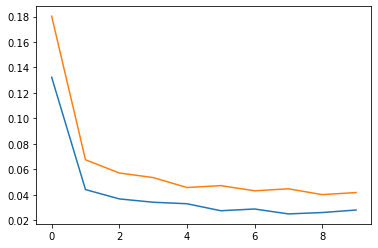

In [ ]:
from torch import optim
from torch.autograd import Variable
from tqdm import tqdm

cnn_power = CNN_Power(1.5)
cnn_normal = CNN_Normal()
loss_func = nn.CrossEntropyLoss()
optimizer_power = optim.Adam(cnn_power.parameters(), lr = 0.01)
optimizer_normal = optim.Adam(cnn_normal.parameters(), lr = 0.01)
num_epochs = 10
weight_cache = {'cnn_power': {'layer_1': [], 'layer_2': []}, 'cnn_normal': {'layer_1': [], 'layer_2': []}}

def train(num_epochs, cnn_power, cnn_normal, loaders):    
    cnn_power.train()
    cnn_power.to(device)
    cnn_normal.train()
    cnn_normal.to(device)

    # Train the model
    total_step = len(loaders['train'])
    losses_power = []
    losses_normal = []
    for epoch in range(num_epochs):
        loss_ep_power = 0
        loss_ep_normal = 0
        cnt = 0
        for (images, labels) in tqdm(loaders['train']):
            images = images.to(device)
            labels = labels.to(device)
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            cnt += 1
            
            # PowerProp
            output_power = cnn_power(b_x)[0]               
            loss_power = loss_func(output_power, b_y)
            loss_ep_power += loss_power.cpu().item()
            optimizer_power.zero_grad()           
            loss_power.backward()
            optimizer_power.step()
            weight_cache['cnn_power']['layer_1'].append(cnn_power.conv1[0].core_weight.detach().cpu().numpy())
            weight_cache['cnn_power']['layer_2'].append(cnn_power.conv2[0].core_weight.detach().cpu().numpy())

            # General CNN
            output_normal = cnn_normal(b_x)[0]               
            loss_normal = loss_func(output_normal, b_y)
            loss_ep_normal += loss_normal.cpu().item()
            optimizer_normal.zero_grad()           
            loss_normal.backward()
            optimizer_normal.step()
            weight_cache['cnn_normal']['layer_1'].append(cnn_normal.conv1[0].weight.detach().cpu().numpy())
            weight_cache['cnn_normal']['layer_2'].append(cnn_normal.conv2[0].weight.detach().cpu().numpy())
            
        losses_power.append(loss_ep_power/cnt)
        losses_normal.append(loss_ep_normal/cnt)
        print(f"Epoch {epoch}, Normal: {loss_ep_normal/cnt}, Power: {loss_ep_power/cnt}")
    plt.figure()
    plt.plot(range(len(losses_power)), losses_power, label='PowerProp')
    plt.plot(range(len(losses_power)), losses_normal, label='Normal')

train(num_epochs, cnn_power, cnn_normal, loaders)

In [ ]:
def test(cnn):
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            correct += (pred_y == labels).cpu().sum().item()
            total += len(labels)
    
    print(correct, total)
    print('Test Accuracy of the model on the 10000 test images: %.2f' % (correct/total))

print("Power")
test(cnn_power)
print("Normal")
test(cnn_normal)

Power
9851 10000
Test Accuracy of the model on the 10000 test images: 0.99
Normal
9856 10000
Test Accuracy of the model on the 10000 test images: 0.99


### Distribution of Weights

In [ ]:
print("Power")
print(cnn_power.conv1[0].core_weight.size())
print(cnn_power.conv2[0].core_weight.size())
print(cnn_power.out.core_weight.size())

print("Normal")
print(cnn_normal.conv1[0].weight.size())
print(cnn_normal.conv2[0].weight.size())
print(cnn_normal.out.weight.size())

Power
torch.Size([16, 1, 5, 5])
torch.Size([32, 16, 5, 5])
torch.Size([10, 1568])
Normal
torch.Size([16, 1, 5, 5])
torch.Size([32, 16, 5, 5])
torch.Size([10, 1568])


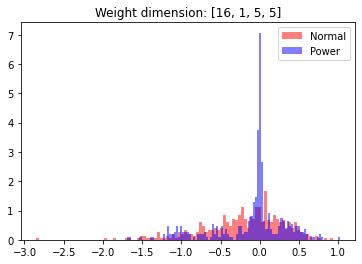

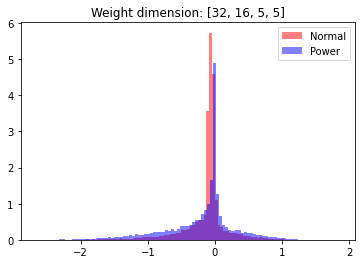

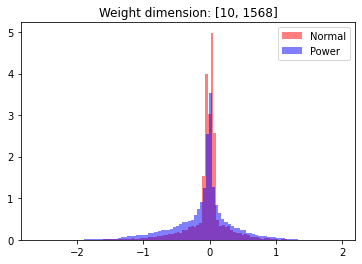

In [ ]:
cnn_power.to('cpu')
cnn_normal.to('cpu')
sizes = []
for layer in cnn_normal.parameters():
    if len(layer.size()) <= 1:
        continue
    sizes.append(layer.size())
for size in sizes:
    weights = []
    for cnn in (cnn_normal, cnn_power):
        for layer in cnn.parameters():
            if layer.size() == size:
                weights_power = layer.detach().numpy().flatten()
                weights.append(weights_power)
    plt.hist(weights[0], bins=100, color = "red", label="Normal", alpha=0.5, density=True)
    plt.hist(weights[1], bins=100, color = "blue", label="Power", alpha=0.5, density=True)
    plt.legend()
    plt.title("Weight dimension: " + str(list(size)))
    plt.show()

### Journey of a Weight


#### Layer 1

In [ ]:
layer_1_power = np.array(weight_cache['cnn_power']['layer_1']).reshape(6000, -1)
layer_1_normal = np.array(weight_cache['cnn_normal']['layer_1']).reshape(6000, -1)
print(layer_1_power.shape)
print(layer_1_normal.shape)

(6000, 400)
(6000, 400)


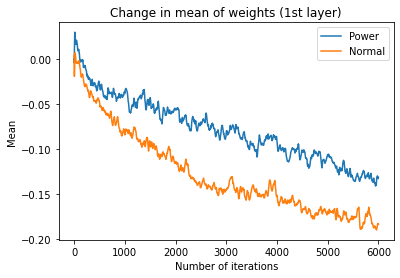

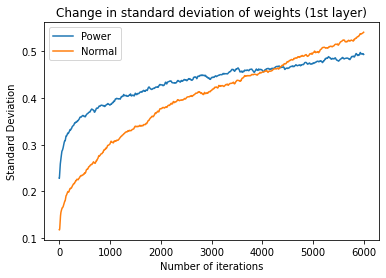

In [ ]:
layer_1_power_mean = np.mean(layer_1_power, axis=1)
layer_1_normal_mean = np.mean(layer_1_normal, axis=1)
layer_1_power_std = np.std(layer_1_power, axis=1)
layer_1_normal_std = np.std(layer_1_normal, axis=1)

plt.figure()
plt.plot(range(layer_1_power.shape[0]), layer_1_power_mean, label='Power')
plt.plot(range(layer_1_normal.shape[0]), layer_1_normal_mean, label='Normal')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Mean')
plt.title('Change in mean of weights (1st layer)')
plt.show()

plt.figure()
plt.plot(range(layer_1_power.shape[0]), layer_1_power_std, label='Power')
plt.plot(range(layer_1_normal.shape[0]), layer_1_normal_std, label='Normal')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Standard Deviation')
plt.title('Change in standard deviation of weights (1st layer)')
plt.show()
# for i in range(layer_1_power.shape[1]):
#     plt.plot(range(layer_1_power.shape[0]), layer_1_power[:,i])

#### Layer 2

In [ ]:
layer_2_power = np.array(weight_cache['cnn_power']['layer_2']).reshape(6000, -1)
layer_2_normal = np.array(weight_cache['cnn_normal']['layer_2']).reshape(6000, -1)
print(layer_2_power.shape)
print(layer_2_normal.shape)

(6000, 12800)
(6000, 12800)


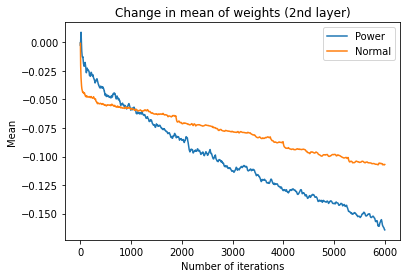

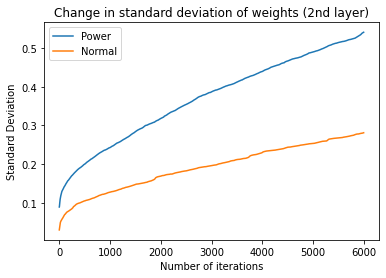

In [ ]:
layer_2_power_mean = np.mean(layer_2_power, axis=1)
layer_2_normal_mean = np.mean(layer_2_normal, axis=1)
layer_2_power_std = np.std(layer_2_power, axis=1)
layer_2_normal_std = np.std(layer_2_normal, axis=1)

plt.figure()
plt.plot(range(layer_2_power.shape[0]), layer_2_power_mean, label='Power')
plt.plot(range(layer_2_normal.shape[0]), layer_2_normal_mean, label='Normal')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Mean')
plt.title('Change in mean of weights (2nd layer)')
plt.show()

plt.figure()
plt.plot(range(layer_2_power.shape[0]), layer_2_power_std, label='Power')
plt.plot(range(layer_2_normal.shape[0]), layer_2_normal_std, label='Normal')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Standard Deviation')
plt.title('Change in standard deviation of weights (2nd layer)')
plt.show()
# for i in range(layer_1_power.shape[1]):
#     plt.plot(range(layer_1_power.shape[0]), layer_1_power[:,i])

### Sparsification

In [ ]:
import copy
cnn_power_copy = copy.deepcopy(cnn_power)
cnn_normal_copy = copy.deepcopy(cnn_normal)

In [ ]:
prune_percent = np.array(range(10))*0.1
prune_percent

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
def test_accuracy(cnn):
    cnn.to(device)
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            correct += (pred_y == labels).cpu().sum().item()
            total += len(labels)    
    return correct

In [ ]:
import torch.nn.utils.prune as prune
import torch.nn.functional as F

prune_percent = np.array(range(40))*0.025
accuracy = {'cnn_power': [], 'cnn_normal': []}

for val in prune_percent:
    cnn_power_pruned = copy.deepcopy(cnn_power_copy)
    prune.l1_unstructured(cnn_power_pruned.conv1[0], name='core_weight', amount=val)
    prune.l1_unstructured(cnn_power_pruned.conv2[0], name='core_weight', amount=val)
    prune.l1_unstructured(cnn_power_pruned.out, name='core_weight', amount=val)
    accuracy['cnn_power'].append(test_accuracy(cnn_power_pruned))
    print("Pruning extent:", val, "(Power) - Accuracy of", accuracy['cnn_power'][-1])

    cnn_normal_pruned = copy.deepcopy(cnn_normal_copy)
    prune.l1_unstructured(cnn_normal_pruned.conv1[0], name='weight', amount=val)
    prune.l1_unstructured(cnn_normal_pruned.conv2[0], name='weight', amount=val)
    prune.l1_unstructured(cnn_normal_pruned.out, name='weight', amount=val)
    accuracy['cnn_normal'].append(test_accuracy(cnn_normal_pruned))
    print("Pruning extent:", val, "(Normal) - Accuracy of", accuracy['cnn_normal'][-1])

Pruning extent: 0.0 (Power) - Accuracy of 9851
Pruning extent: 0.0 (Normal) - Accuracy of 9856
Pruning extent: 0.025 (Power) - Accuracy of 9851
Pruning extent: 0.025 (Normal) - Accuracy of 9857
Pruning extent: 0.05 (Power) - Accuracy of 9851
Pruning extent: 0.05 (Normal) - Accuracy of 9851
Pruning extent: 0.07500000000000001 (Power) - Accuracy of 9852
Pruning extent: 0.07500000000000001 (Normal) - Accuracy of 9853
Pruning extent: 0.1 (Power) - Accuracy of 9851
Pruning extent: 0.1 (Normal) - Accuracy of 9852
Pruning extent: 0.125 (Power) - Accuracy of 9852
Pruning extent: 0.125 (Normal) - Accuracy of 9858
Pruning extent: 0.15000000000000002 (Power) - Accuracy of 9851
Pruning extent: 0.15000000000000002 (Normal) - Accuracy of 9854
Pruning extent: 0.17500000000000002 (Power) - Accuracy of 9851
Pruning extent: 0.17500000000000002 (Normal) - Accuracy of 9863
Pruning extent: 0.2 (Power) - Accuracy of 9850
Pruning extent: 0.2 (Normal) - Accuracy of 9853
Pruning extent: 0.225 (Power) - Accurac

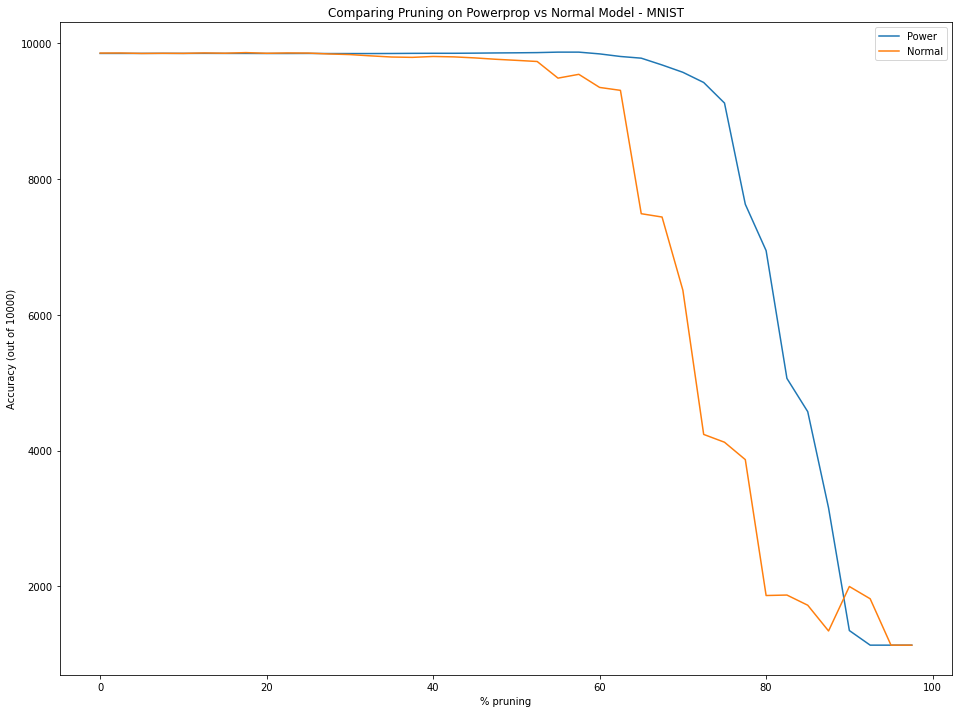

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(np.arange(0, 100, 2.5), accuracy['cnn_power'], label='Power')
plt.plot(np.arange(0, 100, 2.5), accuracy['cnn_normal'], label='Normal')
plt.title('Comparing Pruning on Powerprop vs Normal Model - MNIST')
plt.xlabel('% pruning')
plt.ylabel("Accuracy (out of 10000)")
plt.legend()
plt.show()

# Sanity check ($\alpha=1$)



### Training & Testing

100%|██████████| 600/600 [00:12<00:00, 46.51it/s]


Epoch 0, Normal: 0.19754119522403926, Power: 0.1767123825661838


100%|██████████| 600/600 [00:11<00:00, 51.60it/s]


Epoch 1, Normal: 0.08368044533068314, Power: 0.06654699578454408


100%|██████████| 600/600 [00:09<00:00, 66.07it/s]


Epoch 2, Normal: 0.07229839764030961, Power: 0.05694895569467917


100%|██████████| 600/600 [00:09<00:00, 66.40it/s]


Epoch 3, Normal: 0.06629900482386196, Power: 0.051564168720821424


100%|██████████| 600/600 [00:08<00:00, 67.25it/s]


Epoch 4, Normal: 0.0637367043485089, Power: 0.048742776405027444


100%|██████████| 600/600 [00:08<00:00, 66.67it/s]


Epoch 5, Normal: 0.06298871922073886, Power: 0.048442622162983756


100%|██████████| 600/600 [00:09<00:00, 66.17it/s]


Epoch 6, Normal: 0.06102995973022189, Power: 0.04440846938591373


100%|██████████| 600/600 [00:08<00:00, 67.66it/s]


Epoch 7, Normal: 0.057417818671868494, Power: 0.04220676311226271


100%|██████████| 600/600 [00:09<00:00, 61.81it/s]


Epoch 8, Normal: 0.058357150765368716, Power: 0.04171907279601631


100%|██████████| 600/600 [00:08<00:00, 67.13it/s]


Epoch 9, Normal: 0.05764142907069375, Power: 0.0427287939257197


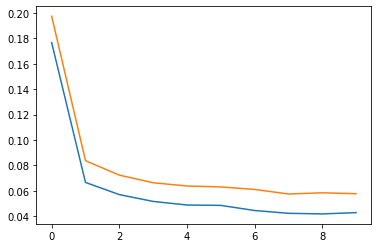

In [ ]:
from torch import optim
from torch.autograd import Variable
from tqdm import tqdm

cnn_power_1 = CNN_Power(1)
cnn_normal = CNN_Normal()
loss_func = nn.CrossEntropyLoss()
optimizer_power = optim.Adam(cnn_power_1.parameters(), lr = 0.01)
optimizer_normal = optim.Adam(cnn_normal.parameters(), lr = 0.01)
num_epochs = 10

def train(num_epochs, cnn_power, cnn_normal, loaders):    
    cnn_power.train()
    cnn_power.to(device)
    cnn_normal.train()
    cnn_normal.to(device)

    # Train the model
    total_step = len(loaders['train'])
    losses_power = []
    losses_normal = []
    for epoch in range(num_epochs):
        loss_ep_power = 0
        loss_ep_normal = 0
        cnt = 0
        for (images, labels) in tqdm(loaders['train']):
            images = images.to(device)
            labels = labels.to(device)
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            cnt += 1
            
            # PowerProp
            output_power = cnn_power(b_x)[0]               
            loss_power = loss_func(output_power, b_y)
            loss_ep_power += loss_power.cpu().item()
            optimizer_power.zero_grad()           
            loss_power.backward()
            optimizer_power.step()

            # General CNN
            output_normal = cnn_normal(b_x)[0]               
            loss_normal = loss_func(output_normal, b_y)
            loss_ep_normal += loss_normal.cpu().item()
            optimizer_normal.zero_grad()           
            loss_normal.backward()
            optimizer_normal.step()
            
        losses_power.append(loss_ep_power/cnt)
        losses_normal.append(loss_ep_normal/cnt)
        print(f"Epoch {epoch}, Normal: {loss_ep_normal/cnt}, Power: {loss_ep_power/cnt}")
    plt.figure()
    plt.plot(range(len(losses_power)), losses_power, label='PowerProp')
    plt.plot(range(len(losses_power)), losses_normal, label='Normal')

train(num_epochs, cnn_power_1, cnn_normal, loaders)

In [ ]:
def test(cnn):
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            correct += (pred_y == labels).cpu().sum().item()
            total += len(labels)
    
    print(correct, total)
    print('Test Accuracy of the model on the 10000 test images: %.2f' % (correct/total))

print("Power")
test(cnn_power_1)
print("Normal")
test(cnn_normal)

Power
9834 10000
Test Accuracy of the model on the 10000 test images: 0.98
Normal
9820 10000
Test Accuracy of the model on the 10000 test images: 0.98


### Distribution of Weights

In [ ]:
print("Power")
print(cnn_power_1.conv1[0].core_weight.size())
print(cnn_power_1.conv2[0].core_weight.size())
print(cnn_power_1.out.core_weight.size())

print("Normal")
print(cnn_normal.conv1[0].weight.size())
print(cnn_normal.conv2[0].weight.size())
print(cnn_normal.out.weight.size())

Power
torch.Size([16, 1, 5, 5])
torch.Size([32, 16, 5, 5])
torch.Size([10, 1568])
Normal
torch.Size([16, 1, 5, 5])
torch.Size([32, 16, 5, 5])
torch.Size([10, 1568])


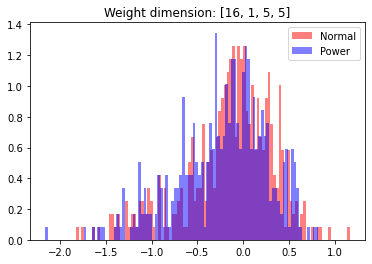

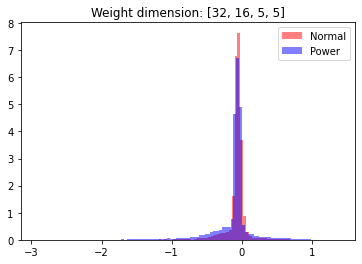

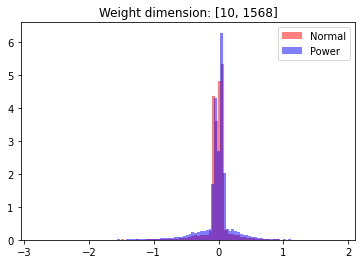

In [ ]:
cnn_power_1.to('cpu')
cnn_normal.to('cpu')
sizes = []
for layer in cnn_normal.parameters():
    if len(layer.size()) <= 1:
        continue
    sizes.append(layer.size())
for size in sizes:
    weights = []
    for cnn in (cnn_normal, cnn_power_1):
        for layer in cnn.parameters():
            if layer.size() == size:
                weights_power = layer.detach().numpy().flatten()
                weights.append(weights_power)
    plt.hist(weights[0], bins=100, color = "red", label="Normal", alpha=0.5, density=True)
    plt.hist(weights[1], bins=100, color = "blue", label="Power", alpha=0.5, density=True)
    plt.legend()
    plt.title("Weight dimension: " + str(list(size)))
    plt.show()

# MNIST with high $\alpha$

### Training & Testing

100%|██████████| 600/600 [00:16<00:00, 35.60it/s]


Epoch 0, Normal: 0.30515316197648645, Power: 0.15676856810459866


100%|██████████| 600/600 [00:16<00:00, 36.15it/s]


Epoch 1, Normal: 0.09897037709131837, Power: 0.06050319456999811


100%|██████████| 600/600 [00:10<00:00, 57.52it/s]


Epoch 2, Normal: 0.08725316393654793, Power: 0.051849157158867454


100%|██████████| 600/600 [00:10<00:00, 57.96it/s]


Epoch 3, Normal: 0.07894896296706672, Power: 0.04899424387821152


100%|██████████| 600/600 [00:10<00:00, 57.78it/s]


Epoch 4, Normal: 0.07627461434419577, Power: 0.044054791080028126


100%|██████████| 600/600 [00:10<00:00, 57.98it/s]


Epoch 5, Normal: 0.07371702862670645, Power: 0.043081623367421946


100%|██████████| 600/600 [00:10<00:00, 58.19it/s]


Epoch 6, Normal: 0.07402576404429662, Power: 0.04406456698421001


100%|██████████| 600/600 [00:10<00:00, 55.13it/s]


Epoch 7, Normal: 0.07404920248974425, Power: 0.042055110979417804


100%|██████████| 600/600 [00:10<00:00, 56.08it/s]


Epoch 8, Normal: 0.07024722977114531, Power: 0.04651653785733894


100%|██████████| 600/600 [00:10<00:00, 57.53it/s]


Epoch 9, Normal: 0.06719062176416628, Power: 0.042330153926547306


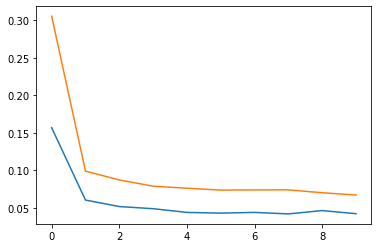

In [ ]:
from torch import optim
from torch.autograd import Variable
from tqdm import tqdm

cnn_power = CNN_Power(4)
cnn_normal = CNN_Normal()
loss_func = nn.CrossEntropyLoss()
optimizer_power = optim.Adam(cnn_power.parameters(), lr = 0.01)
optimizer_normal = optim.Adam(cnn_normal.parameters(), lr = 0.01)
num_epochs = 10

def train(num_epochs, cnn_power, cnn_normal, loaders):    
    cnn_power.to(device)
    cnn_normal.to(device)
    cnn_power.train()
    cnn_normal.train()
    # Train the model
    total_step = len(loaders['train'])
    losses_power = []
    losses_normal = []
    for epoch in range(num_epochs):
        loss_ep_power = 0
        loss_ep_normal = 0
        cnt = 0
        for (images, labels) in tqdm(loaders['train']):
            images = images.to(device)
            labels = labels.to(device)
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            cnt += 1
            
            # PowerProp
            output_power = cnn_power(b_x)[0]               
            loss_power = loss_func(output_power, b_y)
            loss_ep_power += loss_power.item()
            optimizer_power.zero_grad()           
            loss_power.backward()
            optimizer_power.step()

            # General CNN
            output_normal = cnn_normal(b_x)[0]               
            loss_normal = loss_func(output_normal, b_y)
            loss_ep_normal += loss_normal.item()
            optimizer_normal.zero_grad()           
            loss_normal.backward()
            optimizer_normal.step()
            
        losses_power.append(loss_ep_power/cnt)
        losses_normal.append(loss_ep_normal/cnt)
        print(f"Epoch {epoch}, Normal: {loss_ep_normal/cnt}, Power: {loss_ep_power/cnt}")
    plt.figure()
    plt.plot(range(len(losses_power)), losses_power, label='PowerProp')
    plt.plot(range(len(losses_power)), losses_normal, label='Normal')

train(num_epochs, cnn_power, cnn_normal, loaders)

In [ ]:
def test(cnn):
    cnn.to(device)
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            correct += (pred_y == labels).cpu().sum().item()
            total += len(labels)
    
    print(correct, total)
    print('Test Accuracy of the model on the 10000 test images: %.2f' % (correct/total))

print("Power")
test(cnn_power)
print("Normal")
test(cnn_normal)

Power
9840 10000
Test Accuracy of the model on the 10000 test images: 0.98
Normal
9759 10000
Test Accuracy of the model on the 10000 test images: 0.98


### Distribution of Weights

In [ ]:
print("Power")
print(cnn_power.conv1[0].core_weight.size())
print(cnn_power.conv2[0].core_weight.size())
print(cnn_power.out.core_weight.size())

print("Normal")
print(cnn_normal.conv1[0].weight.size())
print(cnn_normal.conv2[0].weight.size())
print(cnn_normal.out.weight.size())

Power
torch.Size([16, 1, 5, 5])
torch.Size([32, 16, 5, 5])
torch.Size([10, 1568])
Normal
torch.Size([16, 1, 5, 5])
torch.Size([32, 16, 5, 5])
torch.Size([10, 1568])


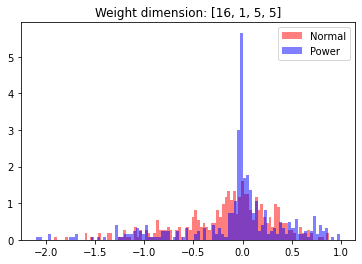

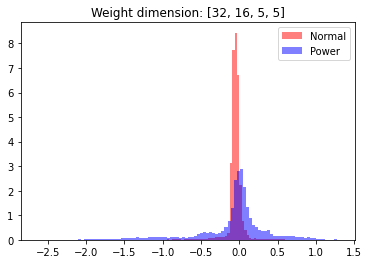

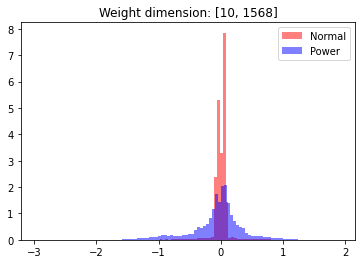

In [ ]:
cnn_power.to('cpu')
cnn_normal.to('cpu')
sizes = []
for layer in cnn_normal.parameters():
    if len(layer.size()) <= 1:
        continue
    sizes.append(layer.size())
for size in sizes:
    weights = []
    for cnn in (cnn_normal, cnn_power):
        for layer in cnn.parameters():
            if layer.size() == size:
                weights_power = layer.detach().numpy().flatten()
                weights.append(weights_power)
    plt.hist(weights[0], bins=100, color = "red", label="Normal", alpha=0.5, density=True)
    plt.hist(weights[1], bins=100, color = "blue", label="Power", alpha=0.5, density=True)
    plt.legend()
    plt.title("Weight dimension: " + str(list(size)))
    plt.show()

# Experiments on CIFAR-10 ($\alpha=1.5$)

### Dataset Preparation

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(
    root = '.',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)
print(train_dataset.data.shape)
print(test_dataset.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_dataset, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

### Model Definition

In [ ]:
class CNN_Power(nn.Module):
    def __init__(self, alpha):
        super(CNN_Power, self).__init__()
        self.alpha = alpha
        self.conv1 = nn.Sequential(Conv2d_Power(alpha, 3, 16, 3, 1, 2,), nn.ReLU(), nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(Conv2d_Power(alpha, 16, 32, 3, 1, 2), nn.ReLU(), nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(Conv2d_Power(alpha, 32, 64, 3, 1, 2), nn.ReLU(), nn.MaxPool2d(2))
        self.conv4 = nn.Sequential(Conv2d_Power(alpha, 64, 128, 3, 1, 2), nn.ReLU(), nn.MaxPool2d(2))
        self.out = Linear_Power(alpha, 1152, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten the output of conv4 to (batch_size, 1152)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [ ]:
class CNN_Normal(nn.Module):
    def __init__(self):
        super(CNN_Normal, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, 3, 1, 2,), nn.ReLU(), nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 2), nn.ReLU(), nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 2), nn.ReLU(), nn.MaxPool2d(2))
        self.conv4 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 2), nn.ReLU(), nn.MaxPool2d(2))
        self.out = nn.Linear(1152, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten the output of conv4 to (batch_size, 1152)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

### Training & Testing

100%|██████████| 500/500 [00:11<00:00, 42.51it/s]


Epoch 0, Normal: 1.8590464522838592, Power: 1.668910621881485


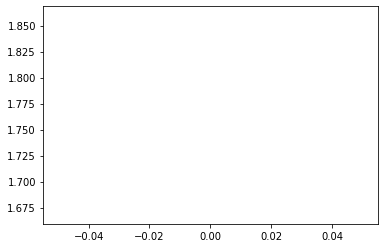

100%|██████████| 500/500 [00:12<00:00, 39.86it/s]


Epoch 1, Normal: 1.6002455644607545, Power: 1.3330919716358185


100%|██████████| 500/500 [00:10<00:00, 45.91it/s]


Epoch 2, Normal: 1.5327551574707032, Power: 1.2445283885002136


100%|██████████| 500/500 [00:10<00:00, 45.73it/s]


Epoch 3, Normal: 1.484753399848938, Power: 1.179689163684845


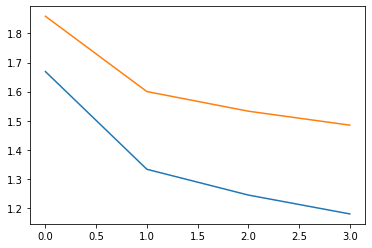

100%|██████████| 500/500 [00:10<00:00, 45.84it/s]


Epoch 4, Normal: 1.4493515274524689, Power: 1.153761619925499


100%|██████████| 500/500 [00:10<00:00, 45.90it/s]


Epoch 5, Normal: 1.4269312489032746, Power: 1.123178875565529


100%|██████████| 500/500 [00:12<00:00, 41.66it/s]


Epoch 6, Normal: 1.4123813350200654, Power: 1.096395258307457


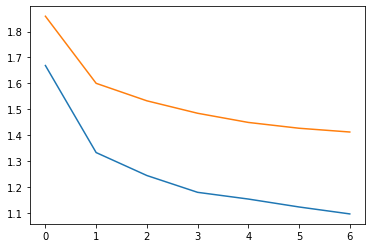

100%|██████████| 500/500 [00:11<00:00, 44.65it/s]


Epoch 7, Normal: 1.4025681805610657, Power: 1.0806695415973664


100%|██████████| 500/500 [00:11<00:00, 42.56it/s]


Epoch 8, Normal: 1.3842580642700195, Power: 1.062920249581337


100%|██████████| 500/500 [00:10<00:00, 45.82it/s]


Epoch 9, Normal: 1.3737488722801208, Power: 1.0627026536464692


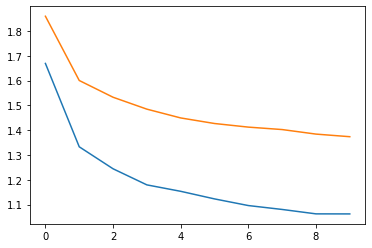

100%|██████████| 500/500 [00:10<00:00, 45.85it/s]


Epoch 10, Normal: 1.3703246116638184, Power: 1.0386167666912078


100%|██████████| 500/500 [00:10<00:00, 45.73it/s]


Epoch 11, Normal: 1.3507181732654572, Power: 1.0365610103607177


100%|██████████| 500/500 [00:11<00:00, 45.17it/s]


Epoch 12, Normal: 1.3444811470508575, Power: 1.0297682305574418


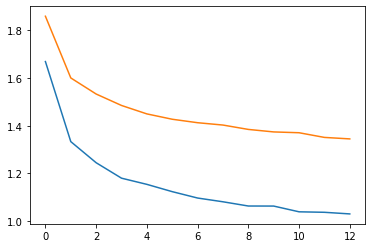

100%|██████████| 500/500 [00:10<00:00, 45.75it/s]


Epoch 13, Normal: 1.3430670249462127, Power: 1.0257294182777406


100%|██████████| 500/500 [00:11<00:00, 45.19it/s]


Epoch 14, Normal: 1.3298924782276154, Power: 1.0244954752922057


100%|██████████| 500/500 [00:11<00:00, 44.98it/s]


Epoch 15, Normal: 1.3272585666179657, Power: 1.016626417517662


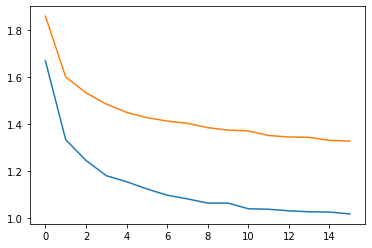

100%|██████████| 500/500 [00:11<00:00, 44.72it/s]


Epoch 16, Normal: 1.3192025866508483, Power: 1.005517530322075


100%|██████████| 500/500 [00:11<00:00, 44.60it/s]


Epoch 17, Normal: 1.3064246575832368, Power: 1.0005239291191101


100%|██████████| 500/500 [00:10<00:00, 45.49it/s]


Epoch 18, Normal: 1.3121095992326737, Power: 1.0027081688642503


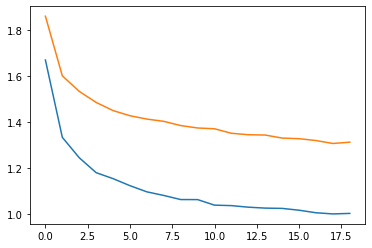

100%|██████████| 500/500 [01:47<00:00,  4.65it/s]

Epoch 19, Normal: 1.2951955490112306, Power: 0.9917861249446869


In [ ]:
from torch import optim
from torch.autograd import Variable
from tqdm import tqdm

cnn_power = CNN_Power(1.5)
cnn_normal = CNN_Normal()
loss_func = nn.CrossEntropyLoss()
optimizer_power = optim.Adam(cnn_power.parameters(), lr = 0.01)
optimizer_normal = optim.Adam(cnn_normal.parameters(), lr = 0.01)
num_epochs = 20


weight_cache = {'cnn_power': {'layer_1': [], 'layer_2': [], 'layer_3': [], 'layer_4': []}, 'cnn_normal': {'layer_1': [], 'layer_2': [], 'layer_3': [], 'layer_4': []}}

def train(num_epochs, cnn_power, cnn_normal, loaders):    
    cnn_power.train()
    cnn_power.to(device)
    cnn_normal.train()
    cnn_normal.to(device)

    # Train the model
    total_step = len(loaders['train'])
    losses_power = []
    losses_normal = []
    for epoch in range(num_epochs):
        loss_ep_power = 0
        loss_ep_normal = 0
        cnt = 0
        for (images, labels) in tqdm(loaders['train']):
            images = images.to(device)
            labels = labels.to(device)
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            cnt += 1
            
            # PowerProp
            output_power = cnn_power(b_x)[0]               
            loss_power = loss_func(output_power, b_y)
            loss_ep_power += loss_power.cpu().item()
            optimizer_power.zero_grad()           
            loss_power.backward()
            optimizer_power.step()
            weight_cache['cnn_power']['layer_1'].append(cnn_power.conv1[0].core_weight.detach().cpu().numpy())
            weight_cache['cnn_power']['layer_2'].append(cnn_power.conv2[0].core_weight.detach().cpu().numpy())
            weight_cache['cnn_power']['layer_3'].append(cnn_power.conv3[0].core_weight.detach().cpu().numpy())
            weight_cache['cnn_power']['layer_4'].append(cnn_power.conv4[0].core_weight.detach().cpu().numpy())

            # General CNN
            output_normal = cnn_normal(b_x)[0]               
            loss_normal = loss_func(output_normal, b_y)
            loss_ep_normal += loss_normal.cpu().item()
            optimizer_normal.zero_grad()           
            loss_normal.backward()
            optimizer_normal.step()
            weight_cache['cnn_normal']['layer_1'].append(cnn_normal.conv1[0].weight.detach().cpu().numpy())
            weight_cache['cnn_normal']['layer_2'].append(cnn_normal.conv2[0].weight.detach().cpu().numpy())
            weight_cache['cnn_normal']['layer_3'].append(cnn_normal.conv3[0].weight.detach().cpu().numpy())
            weight_cache['cnn_normal']['layer_4'].append(cnn_normal.conv4[0].weight.detach().cpu().numpy())

        losses_power.append(loss_ep_power/cnt)
        losses_normal.append(loss_ep_normal/cnt)
        print(f"Epoch {epoch}, Normal: {loss_ep_normal/cnt}, Power: {loss_ep_power/cnt}")
        if epoch%3 == 0:
            plt.figure()
            plt.plot(range(len(losses_power)), losses_power, label='PowerProp')
            plt.plot(range(len(losses_power)), losses_normal, label='Normal')
            plt.show()

train(num_epochs, cnn_power, cnn_normal, loaders)

In [ ]:
def test(cnn):
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            correct += (pred_y == labels).cpu().sum().item()
            total += len(labels)
    
    print(correct, total)
    print('Test Accuracy of the model on the 10000 test images: %.2f' % (correct/total))

print("Power")
test(cnn_power)
print("Normal")
test(cnn_normal)

Power
5971 10000
Test Accuracy of the model on the 10000 test images: 0.60
Normal
5102 10000
Test Accuracy of the model on the 10000 test images: 0.51


### Distribution of Weights

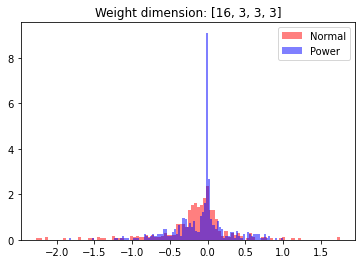

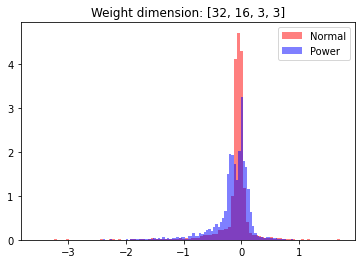

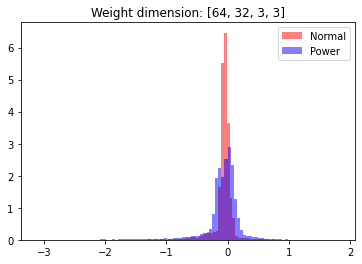

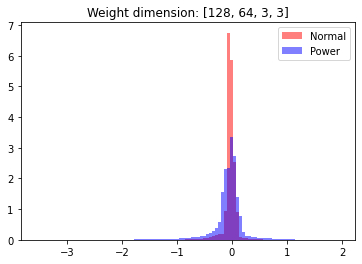

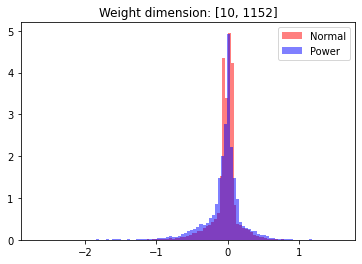

In [ ]:
cnn_power.to('cpu')
cnn_normal.to('cpu')
sizes = []
for layer in cnn_normal.parameters():
    if len(layer.size()) <= 1:
        continue
    sizes.append(layer.size())
for size in sizes:
    weights = []
    for cnn in (cnn_normal, cnn_power):
        for layer in cnn.parameters():
            if layer.size() == size:
                weights_power = layer.detach().numpy().flatten()
                weights.append(weights_power)
    plt.hist(weights[0], bins=100, color = "red", label="Normal", alpha=0.5, density=True)
    plt.hist(weights[1], bins=100, color = "blue", label="Power", alpha=0.5, density=True)
    plt.legend()
    plt.title("Weight dimension: " + str(list(size)))
    plt.show()

### Journey of a Weight


#### Layer 1

In [ ]:
np.array(weight_cache['cnn_power']['layer_1']).shape

(10000, 16, 3, 3, 3)

In [ ]:
layer_1_power = np.array(weight_cache['cnn_power']['layer_1']).reshape(10000, -1)
layer_1_normal = np.array(weight_cache['cnn_normal']['layer_1']).reshape(10000, -1)
print(layer_1_power.shape)
print(layer_1_normal.shape)

(10000, 432)
(10000, 432)


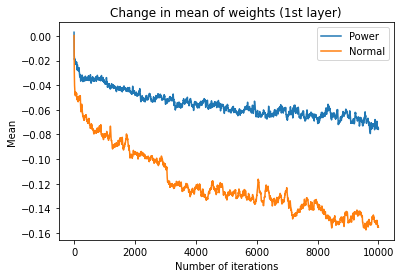

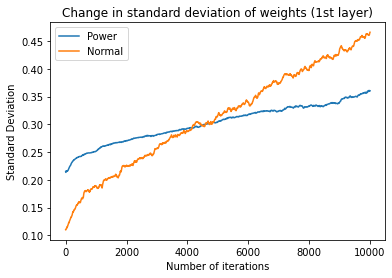

In [ ]:
layer_1_power_mean = np.mean(layer_1_power, axis=1)
layer_1_normal_mean = np.mean(layer_1_normal, axis=1)
layer_1_power_std = np.std(layer_1_power, axis=1)
layer_1_normal_std = np.std(layer_1_normal, axis=1)

plt.figure()
plt.plot(range(layer_1_power.shape[0]), layer_1_power_mean, label='Power')
plt.plot(range(layer_1_normal.shape[0]), layer_1_normal_mean, label='Normal')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Mean')
plt.title('Change in mean of weights (1st layer)')
plt.show()

plt.figure()
plt.plot(range(layer_1_power.shape[0]), layer_1_power_std, label='Power')
plt.plot(range(layer_1_normal.shape[0]), layer_1_normal_std, label='Normal')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Standard Deviation')
plt.title('Change in standard deviation of weights (1st layer)')
plt.show()
# for i in range(layer_1_power.shape[1]):
#     plt.plot(range(layer_1_power.shape[0]), layer_1_power[:,i])

#### Layer 2

In [ ]:
layer_2_power = np.array(weight_cache['cnn_power']['layer_2']).reshape(10000, -1)
layer_2_normal = np.array(weight_cache['cnn_normal']['layer_2']).reshape(10000, -1)
print(layer_2_power.shape)
print(layer_2_normal.shape)

(10000, 4608)
(10000, 4608)


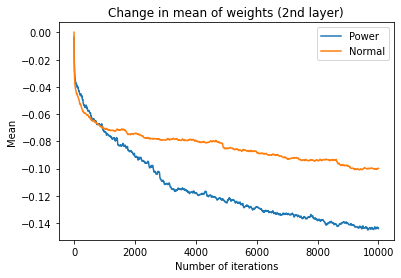

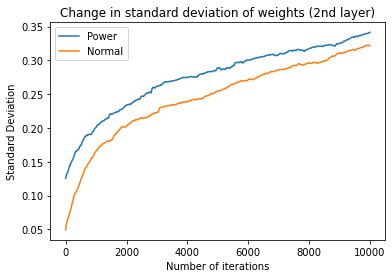

In [ ]:
layer_2_power_mean = np.mean(layer_2_power, axis=1)
layer_2_normal_mean = np.mean(layer_2_normal, axis=1)
layer_2_power_std = np.std(layer_2_power, axis=1)
layer_2_normal_std = np.std(layer_2_normal, axis=1)

plt.figure()
plt.plot(range(layer_2_power.shape[0]), layer_2_power_mean, label='Power')
plt.plot(range(layer_2_normal.shape[0]), layer_2_normal_mean, label='Normal')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Mean')
plt.title('Change in mean of weights (2nd layer)')
plt.show()

plt.figure()
plt.plot(range(layer_2_power.shape[0]), layer_2_power_std, label='Power')
plt.plot(range(layer_2_normal.shape[0]), layer_2_normal_std, label='Normal')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Standard Deviation')
plt.title('Change in standard deviation of weights (2nd layer)')
plt.show()
# for i in range(layer_1_power.shape[1]):
#     plt.plot(range(layer_1_power.shape[0]), layer_1_power[:,i])

### Sparsification

In [ ]:
import copy
cnn_power_copy = copy.deepcopy(cnn_power)
cnn_normal_copy = copy.deepcopy(cnn_normal)

In [ ]:
def test_accuracy(cnn):
    cnn.to(device)
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            correct += (pred_y == labels).cpu().sum().item()
            total += len(labels)    
    return correct

In [ ]:
import torch.nn.utils.prune as prune
import torch.nn.functional as F

prune_percent = np.array(range(40))*0.025
accuracy = {'cnn_power': [], 'cnn_normal': []}

for val in prune_percent:
    cnn_power_pruned = copy.deepcopy(cnn_power_copy)
    prune.l1_unstructured(cnn_power_pruned.conv1[0], name='core_weight', amount=val)
    prune.l1_unstructured(cnn_power_pruned.conv2[0], name='core_weight', amount=val)
    prune.l1_unstructured(cnn_power_pruned.conv3[0], name='core_weight', amount=val)
    prune.l1_unstructured(cnn_power_pruned.conv4[0], name='core_weight', amount=val)
    prune.l1_unstructured(cnn_power_pruned.out, name='core_weight', amount=val)
    accuracy['cnn_power'].append(test_accuracy(cnn_power_pruned))
    print("Pruning extent:", val, "(Power) - Accuracy of", accuracy['cnn_power'][-1])

    cnn_normal_pruned = copy.deepcopy(cnn_normal_copy)
    prune.l1_unstructured(cnn_normal_pruned.conv1[0], name='weight', amount=val)
    prune.l1_unstructured(cnn_normal_pruned.conv2[0], name='weight', amount=val)
    prune.l1_unstructured(cnn_normal_pruned.conv3[0], name='weight', amount=val)
    prune.l1_unstructured(cnn_normal_pruned.conv4[0], name='weight', amount=val)
    prune.l1_unstructured(cnn_normal_pruned.out, name='weight', amount=val)
    accuracy['cnn_normal'].append(test_accuracy(cnn_normal_pruned))
    print("Pruning extent:", val, "(Normal) - Accuracy of", accuracy['cnn_normal'][-1])

Pruning extent: 0.0 (Power) - Accuracy of 5971
Pruning extent: 0.0 (Normal) - Accuracy of 5102
Pruning extent: 0.025 (Power) - Accuracy of 5974
Pruning extent: 0.025 (Normal) - Accuracy of 5104
Pruning extent: 0.05 (Power) - Accuracy of 5973
Pruning extent: 0.05 (Normal) - Accuracy of 5091
Pruning extent: 0.07500000000000001 (Power) - Accuracy of 5975
Pruning extent: 0.07500000000000001 (Normal) - Accuracy of 5078
Pruning extent: 0.1 (Power) - Accuracy of 5980
Pruning extent: 0.1 (Normal) - Accuracy of 5108
Pruning extent: 0.125 (Power) - Accuracy of 5981
Pruning extent: 0.125 (Normal) - Accuracy of 5137
Pruning extent: 0.15000000000000002 (Power) - Accuracy of 5979
Pruning extent: 0.15000000000000002 (Normal) - Accuracy of 5177
Pruning extent: 0.17500000000000002 (Power) - Accuracy of 5988
Pruning extent: 0.17500000000000002 (Normal) - Accuracy of 5201
Pruning extent: 0.2 (Power) - Accuracy of 5961
Pruning extent: 0.2 (Normal) - Accuracy of 5235
Pruning extent: 0.225 (Power) - Accurac

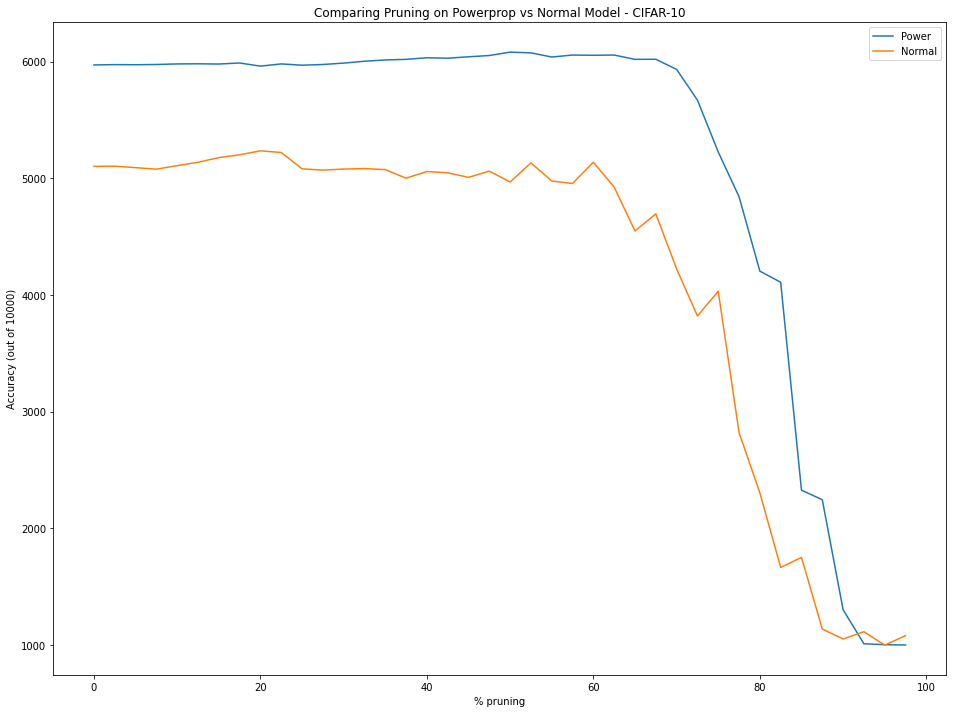

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(np.arange(0, 100, 2.5), accuracy['cnn_power'], label='Power')
plt.plot(np.arange(0, 100, 2.5), accuracy['cnn_normal'], label='Normal')
plt.title('Comparing Pruning on Powerprop vs Normal Model - CIFAR-10')
plt.xlabel('% pruning')
plt.ylabel("Accuracy (out of 10000)")
plt.legend()
plt.show()